# Preparación de datos

In [1]:
# importo las librerías
import pandas as pd
import numpy as np

# defino la URL del dataset
csv_url = "https://raw.githubusercontent.com//ITACADEMYprojectes//projecteML//main//bank_dataset.CSV"

df = pd.read_csv(csv_url)

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59.0,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56.0,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41.0,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55.0,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54.0,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


Para mi proyecto, necesito las características demográficas y financieras de los clientes, así que creo un *dataframe* que contenga únicamente estas variables. Incluyo todas las variables demográficas y financieras ya que, tal y como he visto durante el análisis exploratorio de datos, todas pueden ser relevantes para el modelo. 

In [2]:
df = df[['age','job','marital','education','default','balance','housing','loan','deposit']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11152 non-null  float64
 1   job        11162 non-null  object 
 2   marital    11157 non-null  object 
 3   education  11155 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11162 non-null  int64  
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   deposit    11162 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 785.0+ KB


El *dataframe* tiene 11162 filas y 9 columnas.

### Imputación de valores faltantes

In [3]:
df.isnull().sum()

age          10
job           0
marital       5
education     7
default       0
balance       0
housing       0
loan          0
deposit       0
dtype: int64

Hay tres columnas que contienen valores *null*: `age`, `marital` y `education`. 

Dado que los valores que faltan estan relacionados con los datos demográficos de los clientes, utilizo el resto de datos disponibles como guía para imputar los faltantes: 
* `age`: mediana de edad de clientes con el mismo trabajo, estado civil y educación
* `marital`: moda de estado civil de clientes con el mismo trabajo y edad
* `education`: moda de educación de clientes con el mismo trabajo y edad

In [4]:
# sustituir 'age'
median_age = df.groupby(['job', 'marital','education'])['age'].transform(lambda x: x.median() if not x.isnull().all() else None)
df['age'] = df['age'].fillna(round(median_age))

# sustituir 'marital'
mode_marital = df.groupby(['job', 'age'])['marital'].transform(lambda x: x.mode()[0] if not x.isnull().all() else None)
df['marital'] = df['marital'].fillna(mode_marital)

# sustituir 'education'
mode_education = df.groupby(['job', 'age'])['education'].transform(lambda x: x.mode()[0] if not x.isnull().all() else None)
df['education'] = df['education'].fillna(mode_education)

In [5]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
deposit      0
dtype: int64

Se han imputado correctamente los valores faltantes.

### Tratamiento de valores desconocidos *(unknown)*

Muestro las categorias de las variables categóricas.

In [6]:
for column in df.select_dtypes(include=['object']).columns:
    print(f"La variable {column.upper()} tiene categorias: {df[column].nunique()}\
    \n{df[column].value_counts()}\
    \n \n------------------------\n")

La variable JOB tiene categorias: 12    
job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64    
 
------------------------

La variable MARITAL tiene categorias: 3    
marital
married     6353
single      3518
divorced    1291
Name: count, dtype: int64    
 
------------------------

La variable EDUCATION tiene categorias: 4    
education
secondary    5479
tertiary     3687
primary      1500
unknown       496
Name: count, dtype: int64    
 
------------------------

La variable DEFAULT tiene categorias: 2    
default
no     10994
yes      168
Name: count, dtype: int64    
 
------------------------

La variable HOUSING tiene categorias: 2    
housing
no     5881
yes    5281
Name: count, dtype: int64    
 
------------------------

La variable LOAN

Las variables `job` y `education` tienen categorías *unknown*. Para tratarlas, utilizo la misma estrategia que para imputar valores faltantes:
* `job`: moda de trabajo de clientes con el misma educación y edad; en caso de que no se rellenen todos, aplico de nuevo la imputación teniendo en cuenta únicamente la moda de trabajo de clientes con la misma edad
* `education`: moda de educación de clientes con el mismo trabajo y edad; en caso de que no se rellenen todos, aplico de nuevo la imputación teniendo en cuenta únicamente la moda de educación de clientes con el mismo trabajo

In [7]:
# sustituir 'job'
mode_job = df.groupby(['education', 'age'])['job'].transform(lambda x: x.mode()[0] if not x.isnull().all() else None)
df.loc[df['job'] == 'unknown', 'job'] = mode_job

mode_job2 = df.groupby(['age'])['job'].transform(lambda x: x.mode()[0] if not x.isnull().all() else None)
df.loc[df['job'] == 'unknown', 'job'] = mode_job2

In [8]:
# sustituir 'education'
mode_education = df.groupby(['job', 'age'])['education'].transform(lambda x: x.mode()[0] if not x.isnull().all() else None)
df.loc[df['education'] == 'unknown', 'education'] = mode_education

mode_education2 = df.groupby(['job'])['education'].transform(lambda x: x.mode()[0] if not x.isnull().all() else None)
df.loc[df['education'] == 'unknown', 'education'] = mode_education2

In [9]:
df[(df['job'] == 'unknown') | (df['education'] == 'unknown')]

,age,job,marital,education,default,balance,housing,loan,deposit


Se han imputado todos los valores desconocidos.

### Tratamiento de *outliers*

Tal y como he visto en el análisis exploratorio, las variables `age` y `balance` presentaban *outliers*. En lugar de eliminar directamente esos *outliers* (ya que suponen un porcentaje considerable del total), creo un segundo *dataframe* y los trato con la técnica de winsorización.

In [10]:
from scipy.stats.mstats import winsorize

df_winsorized = df.copy()

# reemplazo los outliers por el valor del percentil 95 o 5 más cercano
df_winsorized['age'] = winsorize(df_winsorized['age'], limits = [0.05, 0.05], inplace = True)
df_winsorized['balance'] = winsorize(df_winsorized['balance'], limits = [0.05, 0.05], inplace = True)

### Dividir el conjunto de datos

Separo el conjunto de datos en datos de entrenamiento y de prueba siguiendo los siguientes criterios:
* 75% datos de entrenamiento, 25% datos de prueba
* stratify de la variable objetivo (depósito) para mantener la misma proporción de clientes que contratan o no el producto financiero
* random_state = 0 para que la selección sea aleatoria

Dado que quiero utilizar modelo supervisado, separo las características de las etiquetas. 

In [11]:
df_winsorized.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'deposit'],
      dtype='object')

In [12]:
from sklearn.model_selection import train_test_split

X = df_winsorized.loc[:,['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan']]
Y = df_winsorized.loc[:,['deposit']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0, stratify=Y)

print(f'Los datos de entrenamiento contienen {X_train.shape[0]} filas, {X_train.shape[1]} características y {Y_train.shape[1]} etiqueta.')
print(f'Los datos de prueba contienen {X_test.shape[0]} filas, {X_test.shape[1]} características y {Y_test.shape[1]} etiqueta.')

Los datos de entrenamiento contienen 8371 filas, 8 características y 1 etiqueta.
Los datos de prueba contienen 2791 filas, 8 características y 1 etiqueta.


### Codificación de variables categóricas

#### Label Encoding

Utilizo **Label Encoding** para las características `default`, `loan` y `housing` y la etiqueta `deposit`, ya que son binarias (yes/no). También utilizo este método para la característica `education`, al ser variable ordinal. 

In [13]:
binary_variable = ['default', 'loan', 'housing']

numeric_education = {'primary' : 1,
                     'secondary' : 2,
                     'tertiary' : 3}

for variable in binary_variable:
    X_train[variable] = X_train[variable].map({'no': 0, 'yes': 1}).astype(int)
    X_test[variable] = X_test[variable].map({'no': 0, 'yes': 1}).astype(int)

X_train['education'] = X_train['education'].map(numeric_education).astype(int)
X_test['education'] = X_test['education'].map(numeric_education).astype(int)

# convierto la etiqueta 'deposit' en 0 y 1, tanto de datos de entrenamiento como de prueba
Y_train['deposit'] = Y_train['deposit'].map({'no': 0, 'yes': 1}).astype(int)
Y_test['deposit'] = Y_test['deposit'].map({'no': 0, 'yes': 1}).astype(int)

In [14]:
X_train.head()

,age,job,marital,education,default,balance,housing,loan
3557,29.0,unemployed,single,3,0,70,0,0
1337,61.0,retired,married,2,0,6027,0,0
2497,36.0,management,married,3,0,2987,1,0
5575,37.0,self-employed,married,3,0,0,0,0
5045,43.0,management,married,3,0,0,0,0


In [15]:
Y_test.head()

,deposit
730,1
3781,1
6381,0
3944,1
9851,0


#### One-Hot-Encoding

Utilizo **One-Hot Encoding** para las características `job` y `marital`.

Antes de aplicar la codificación, agrupo las categorías de `job` para reducir la dimensionalidad, siguiendo el siguiente criterio:
* categorías sin agrupar: management, blue-collar, technician, admin. (para mantener el detalle de los grupos más representativos)
* servicios y atención al cliente: services, housemaid
* trabajadores independientes y emprendedores: self-employed, entrepreneur
* sin empleo o inactivos: unemployed, retired, student

In [16]:
grouped_jobs = {'management': 'management',
                'blue-collar': 'blue-collar',
                'technician': 'technician',
                'admin.': 'admin.',  
                'services': 'services_group',
                'housemaid': 'services_group',
                'self-employed': 'independent_group',
                'entrepreneur': 'independent_group',
                'unemployed': 'inactive_group',
                'retired': 'inactive_group',
                'student': 'inactive_group'}

X_train['job'] = X_train['job'].map(grouped_jobs)
X_test['job'] = X_test['job'].map(grouped_jobs)

In [17]:
X_train['job'].value_counts()

job
management           1949
blue-collar          1452
technician           1370
inactive_group       1124
admin.               1001
services_group        907
independent_group     568
Name: count, dtype: int64

In [18]:
X_train

,age,job,marital,education,default,balance,housing,loan
3557,29.0,inactive_group,single,3,0,70,0,0
1337,61.0,inactive_group,married,2,0,6027,0,0
2497,36.0,management,married,3,0,2987,1,0
5575,37.0,independent_group,married,3,0,0,0,0
5045,43.0,management,married,3,0,0,0,0
...,...,...,...,...,...,...,...,...
7666,47.0,technician,married,3,0,545,1,0
2707,26.0,management,single,3,0,808,0,0
9523,46.0,management,single,2,0,244,1,0
5303,33.0,technician,married,2,0,2362,1,0


In [19]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

encoded_X_train = X_train.copy()
encoded_X_test = X_test.copy()

encoding_variable = ['job', 'marital']

for variable in encoding_variable:
    # encoding de datos de entrenamiento
    encoded_train_results = encoder.fit_transform(X_train[[variable]])
    encoded_train_columns = pd.DataFrame(encoded_train_results.toarray(), 
                                         columns=encoder.get_feature_names_out([variable]), 
                                         index=X_train.index)
    encoded_X_train = pd.concat([encoded_X_train, encoded_train_columns], axis="columns")

    # encoding de datos de prueba
    encoded_test_results = encoder.fit_transform(X_test[[variable]])
    encoded_test_columns = pd.DataFrame(encoded_test_results.toarray(), 
                                         columns=encoder.get_feature_names_out([variable]), 
                                         index=X_test.index)
    encoded_X_test = pd.concat([encoded_X_test, encoded_test_columns], axis="columns")

# elimino las columnas categoricas iniciales
encoded_X_train = encoded_X_train.drop(columns=encoding_variable)
encoded_X_test = encoded_X_test.drop(columns=encoding_variable)

In [20]:
print(f'Los datos de entrenamiento contienen {encoded_X_train.shape[0]} filas, {encoded_X_train.shape[1]} características y {Y_train.shape[1]} etiqueta.')
print(f'Los datos de prueba contienen {encoded_X_test.shape[0]} filas, {encoded_X_test.shape[1]} características y {Y_test.shape[1]} etiqueta.')

Los datos de entrenamiento contienen 8371 filas, 16 características y 1 etiqueta.
Los datos de prueba contienen 2791 filas, 16 características y 1 etiqueta.


In [21]:
encoded_X_train.head()

,age,education,default,balance,housing,loan,job_admin.,job_blue-collar,job_inactive_group,job_independent_group,job_management,job_services_group,job_technician,marital_divorced,marital_married,marital_single
3557,29.0,3,0,70,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1337,61.0,2,0,6027,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2497,36.0,3,0,2987,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5575,37.0,3,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5045,43.0,3,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [22]:
encoded_X_test.head()

,age,education,default,balance,housing,loan,job_admin.,job_blue-collar,job_inactive_group,job_independent_group,job_management,job_services_group,job_technician,marital_divorced,marital_married,marital_single
730,46.0,3,0,4,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3781,61.0,2,0,1574,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6381,31.0,2,0,290,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3944,61.0,2,0,2801,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9851,45.0,3,0,6027,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


Después de aplicar las técnicas de codificación, observamos que todas las variables son numéricas. Además, pasamos de tener 9 a 16 características. 

### Estandarización de características

La estandarización ayuda a que cada característica contribuya de manera equitativa en el modelo, lo que es esencial para obtener resultados significativos y fiables en modelos y técnicas sensibles a la escala.

En recursos adicionales, he visto que no es necesario estandarizar las variables categóricas que fueron codificadas con Label-Encoding o One-Hot-Encoding, es decir, ya están en una escala consistente y lista para su uso en modelos. Por tanto, únicamente estandarizo las variables `age` y `balance`.

In [23]:
from sklearn.preprocessing import StandardScaler

# selecciono solo las columnas a estandarizar
scale_variable = ['age', 'balance']

# creo el escalador 
scaler = StandardScaler()

# ajusto el escalador y aplico la estandarización a los datos de entrenamiento
encoded_X_train[scale_variable] = scaler.fit_transform(encoded_X_train[scale_variable])

# aplico la estandarizacion a los datos de prueba
encoded_X_test[scale_variable] = scaler.transform(encoded_X_test[scale_variable])

In [24]:
encoded_X_train.head()

,age,education,default,balance,housing,loan,job_admin.,job_blue-collar,job_inactive_group,job_independent_group,job_management,job_services_group,job_technician,marital_divorced,marital_married,marital_single
3557,-1.124433,3,0,-0.716704,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1337,1.918648,2,0,2.848559,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2497,-0.458759,3,0,1.029120,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5575,-0.363663,3,0,-0.758599,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5045,0.206915,3,0,-0.758599,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Reducción de dimensionalidad

Utilizaré los datos sin reducir la dimensionalidad, ya que mi modelo principal es Random Forest y los árboles seleccionan automáticamente las características relevantes en cada partición, lo que hace que la reducción de dimensionalidad no sea tan necesaria.

# Entrenamiento de modelos

### *Clustering* exploratorio

Ejecuto el clustering *K-means* para ver si puedo identificar subgrupos de clientes en los datos.

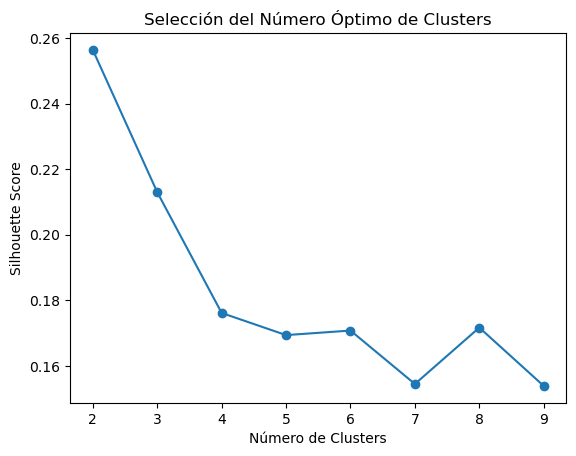

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# uno los datos de entrenamiento y prueba, ya que simplemente quiero estudiar la estructura de los datos
X_combined = pd.concat([encoded_X_train, encoded_X_test], axis=0)

# pruebo diferentes clústers para elegir el óptimo, usando silhouette score como guía
range_n_clusters = range(2, 10)
silhouette_avg_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_combined)
    silhouette_avg = silhouette_score(X_combined, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)

# visualizo el silhouette score
plt.plot(range_n_clusters, silhouette_avg_scores, marker='o')
plt.xlabel("Número de Clusters")
plt.ylabel("Silhouette Score")
plt.title("Selección del Número Óptimo de Clusters")
plt.show()

El *silhouette score* más alto es de 0.26, un valor relativamente bajo, lo cual sugiere que los clusters no estan bien definidos, es decir, que no capturan bien la complejidad de los datos. Aún así, entreno el modelo para ver si puedo identificar diferencias importantes entre los clusters que me puedan ayudar a interpretar los modelos de clasificación. 

In [26]:
# entreno el modelo con el número óptimo de clusters
optimal_clusters = range_n_clusters[silhouette_avg_scores.index(max(silhouette_avg_scores))]
print(f"Número óptimo de clusters: {optimal_clusters}")

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_combined)

# agrego las etiquetas de clusters a los datos originales
X_combined['cluster'] = cluster_labels

Número óptimo de clusters: 2


In [27]:
X_combined.head()

,age,education,default,balance,housing,loan,job_admin.,job_blue-collar,job_inactive_group,job_independent_group,job_management,job_services_group,job_technician,marital_divorced,marital_married,marital_single,cluster
3557,-1.124433,3,0,-0.716704,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1337,1.918648,2,0,2.848559,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2497,-0.458759,3,0,1.029120,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
5575,-0.363663,3,0,-0.758599,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
5045,0.206915,3,0,-0.758599,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0


In [28]:
X_combined.groupby('cluster').mean()

,age,education,default,balance,housing,loan,job_admin.,job_blue-collar,job_inactive_group,job_independent_group,job_management,job_services_group,job_technician,marital_divorced,marital_married,marital_single
cluster,,,,,,,,,,,,,,,,
0,-0.107822,2.189393,0.018418,-0.418428,0.497726,0.147121,0.127815,0.188395,0.117830,0.065017,0.221458,0.113614,0.165872,0.114501,0.549540,0.335959
1,0.460697,2.247092,0.000931,1.756617,0.369940,0.062355,0.088879,0.125174,0.204746,0.068404,0.273616,0.083295,0.155886,0.120521,0.651466,0.228013


Parece ser que hay mayor diferencia en las variables `age` y `balance`:
* Cluster 0: promedio negativo en ambas variables, lo cual sugiere que los clientes de este grupo podrían ser más jóvenes y con saldos más bajos.
* Cluster 1: promedio positivo en ambas variables, lo cual sugiere que los clientes podrían ser mayores y con más ahorros. 

En las variables `default`, `housing` y `loan`: 
* Cluster 0: promedio de incumplimiento bajo pero superior respecto el otro cluster, lo cual sugiere que podrían haber más clientes morosos en este grupo; mayor promedio en las variables de préstamo de vivienda o personal, lo cual sugiere que tienen más compromisos con el banco. 
* Cluster 1: respecto el cluster 0, parece ser que estos clientes podrían tener menos deudas con el banco y, por tanto, mayor estabilidad financiera.

En la variable `job`:
* Cluster 0: promedios más elevados en trabajos administrativos, obreros (blue-collar) y servicios (services + housemaid) en comparación al cluster 1 -  trabajos más técnicos/manuales 
* Cluster 1: promedios más elevados en trabajos de gestión (management) e independientes (entrepreneur + self-employed) y, además, presenta mayor proporción de clientes inactivos (student, unemployed, retired) 

En la variable `marital`:
* Cluster 0: mayor promedio de clientes solteros respecto el cluster 1.
* Cluster 1: mayor promedio de clientes casados respecto el cluster 0.


**En resumen**: los clientes que pertenecen al cluster 1 parece que se encuentran en una situación financiera más favorable (mayor saldo, menos préstamos, trabajos de mayor responsabilidad), por lo que podrían tener mayor predisposición a contratar depósitos a plazo. 

### Regresión Logística

Para mi proyecto, me interesa que los clientes que se suscriben a depósito sean identificados correctamente, de modo que primero de todo hago una validación cruzada para ver el desempeño del modelo de regresión logística con diferentes conjuntos de datos usando las métricas *accuracy* y *recall*. 

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logistic_reg = LogisticRegression()

# validación cruzada de 10 pliegues
cv_scores_accuracy = cross_val_score(logistic_reg, encoded_X_train, Y_train.values.ravel(), cv=10, scoring='accuracy')
cv_scores_recall = cross_val_score(logistic_reg, encoded_X_train, Y_train.values.ravel(), cv=10, scoring='recall')

print("Puntuación de accuracy en la validación cruzada:", cv_scores_accuracy)
print("Media de Accuracy:", cv_scores_accuracy.mean())
print("Desviación Estándar:", cv_scores_accuracy.std())

print("\nPuntuación de recall en la validación cruzada:", cv_scores_recall)
print("Media de Recall:", cv_scores_recall.mean())
print("Desviación Estándar:", cv_scores_recall.std())


Puntuación de accuracy en la validación cruzada: [0.62410501 0.65352449 0.60812425 0.62007168 0.6260454  0.64516129
 0.62962963 0.62126643 0.61887694 0.63201912]
Media de Accuracy: 0.6278824247297571
Desviación Estándar: 0.012530548324066563

Puntuación de recall en la validación cruzada: [0.57178841 0.59193955 0.53904282 0.5768262  0.59949622 0.59697733
 0.55163728 0.56060606 0.53787879 0.57070707]
Media de Recall: 0.5696899727756152
Desviación Estándar: 0.021316744774237457


Observamos que la desviación estándar es baja, con lo cual los resultados son consistentes entre los diferentes pliegues. Sin embargo, las métricas no son del todo buenas: 
* *accuracy*: el modelo clasifica correctamente unicamente el 62.8% de los clientes 
* *recall*: el modelo captura correctamente tan solo el 56.9% de los clientes que contratarían el depósito, es decir, el modelo falla en clasificar correctamente prácticamente a la mitad de los clientes; esto es importante, ya que realmente me interesa clasificar correctamente a los clientes que contratan el depósito para saber a qué perfiles dirigir las campañas de marketing 

Estos resultados no son del todo satisfactorios, lo cual me hace pensar que el modelo de regresión logística no es el más adecuado para capturar las relaciones en los datos o hay algunas características que introducen ruido en el modelo. 

Voy a realizar los mismos pasos con el modelo Random Forest para ver si mejora el rendimiento y entonces entrenaré el modelo que tenga las mejores métricas.

### Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

random_forest = RandomForestClassifier()

# validación cruzada de 10 pliegues
cv_scores_accuracy = cross_val_score(random_forest, encoded_X_train, Y_train.values.ravel(), cv=10, scoring='accuracy')
cv_scores_recall = cross_val_score(random_forest, encoded_X_train, Y_train.values.ravel(), cv=10, scoring='recall')

print("Puntuación de accuracy en la validación cruzada:", cv_scores_accuracy)
print("Media de Accuracy:", cv_scores_accuracy.mean())
print("Desviación Estándar:", cv_scores_accuracy.std())

print("\nPuntuación de recall en la validación cruzada:", cv_scores_recall)
print("Media de Recall:", cv_scores_recall.mean())
print("Desviación Estándar:", cv_scores_recall.std())

Puntuación de accuracy en la validación cruzada: [0.66825776 0.65710872 0.6260454  0.609319   0.63679809 0.64157706
 0.64396655 0.63679809 0.62246117 0.62724014]
Media de Accuracy: 0.6369571974006496
Desviación Estándar: 0.01625984957857048

Puntuación de recall en la validación cruzada: [0.63224181 0.62216625 0.58690176 0.55667506 0.63476071 0.61209068
 0.57934509 0.57070707 0.55555556 0.60858586]
Media de Recall: 0.5959029845049996
Desviación Estándar: 0.028460241629413286


La desviación estándar sigue siendo baja, por lo que los resultados son consistentes entre los diferentes pliegues. 

En cuanto a las métricas, observamos muy poca mejora: 
* *accuracy*: este modelo clasifica correctamente el 63.7% de los clientes (+0.9% respecto la Regresión Logística)
* *recall*: este modelo captura correctamente el 59.6% de los clientes que contratan el depósito (+2.7% respecto la Regresión Logística)

Estos resultados siguen siendo insatisfactorios, así que es posible que se estén utilizando características poco relevantes para el modelo. Además, en este proyecto no estoy considerando la optimización de hiperparámetros, con lo cual el rendimiento puede verse afectado por utilizar los valores predeterminados. 

Voy a entrenar este modelo para analizar las métricas y evaluar la importancia de las características. 

In [31]:
# entreno el modelo con los datos de entrenamiento
random_forest = RandomForestClassifier() 
random_forest.fit(encoded_X_train, Y_train.values.ravel())

# realizo predicciones con los datos de prueba
Y_pred = random_forest.predict(encoded_X_test)

Accuracy: 0.6302400573271228

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.65      0.65      0.65      1469
           1       0.61      0.60      0.61      1322

    accuracy                           0.63      2791
   macro avg       0.63      0.63      0.63      2791
weighted avg       0.63      0.63      0.63      2791



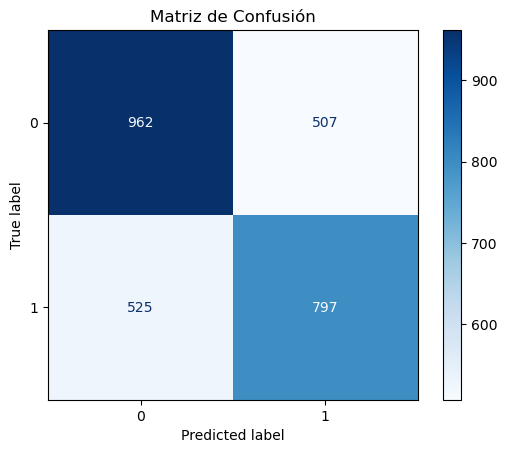

In [32]:
# evalúo el modelo
accuracy = accuracy_score(Y_test, Y_pred)
class_report = classification_report(Y_test, Y_pred)

print("Accuracy:", accuracy)
print("\nReporte de Clasificación:\n", class_report)

# represento la matriz de confusión
ConfusionMatrixDisplay.from_estimator(random_forest, encoded_X_test, Y_test, cmap="Blues")
plt.title("Matriz de Confusión")
plt.show()

En general, el modelo clasifica correctamente el 63% de los clientes de la muestra de prueba. 

Concretamente: 
* Clase 0 - no contrataron depósito: el 65% de las clasificaciones son correctas, y se identificaron bien el 65% de los clientes que no contrataron el depósito. 
* Clase 1 - sí contrataron depósito: el 61% de las clasificaciones son correctas, y se identificaron bien el 60% de los clientes que efectivamente contrataron el depósito.

Se clasifican mejor los clientes que no contrataron el depósito. 

Los valores de *F1-score* están en el rango de 0.61-0.65, lo cual confirma que el modelo tiene un rendimiento relativamente cercano para identificar ambas clases.   

**En resumen**: el modelo tiene un rendimiento "aceptable", pero está lejos de ser perfecto, sobretodo para clasificar a los clientes que contrataron el depósito. No podemos confiar completamente en los resultados de la clasificación, por tanto se debería utilizar con precaución para tomar decisiones empresariales. Probablemente, el rendimiento de este modelo se podría mejorar mediante la optimización de los hiperparámetros o seleccionando características más adecuadas.


Importancia de las Características:
            Característica  Importancia
3                 balance     0.466738
0                     age     0.316662
4                 housing     0.041248
1               education     0.040505
5                    loan     0.022120
8      job_inactive_group     0.015046
14        marital_married     0.011627
12         job_technician     0.011619
7         job_blue-collar     0.011104
6              job_admin.     0.010288
11     job_services_group     0.010167
10         job_management     0.009761
15         marital_single     0.009736
9   job_independent_group     0.009143
13       marital_divorced     0.007781
2                 default     0.006453


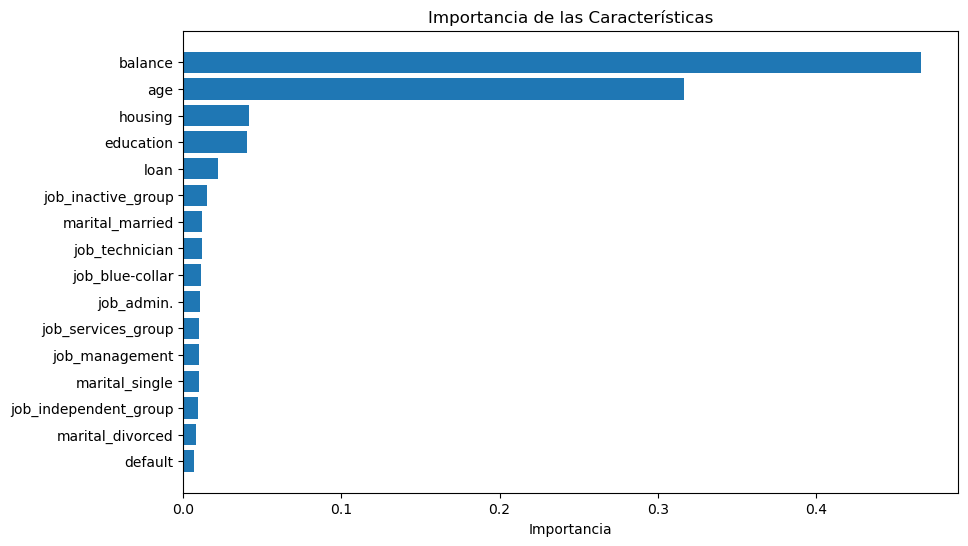

In [33]:
# evalúo la importancia de las características
feature_importances = random_forest.feature_importances_
importance_df = pd.DataFrame({
                            'Característica': encoded_X_train.columns,
                            'Importancia': feature_importances
                            }).sort_values(by='Importancia', ascending=False)

print("\nImportancia de las Características:\n", importance_df)

# visualizo de importancia de características
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Característica'], importance_df['Importancia'])
plt.gca().invert_yaxis() 
plt.title("Importancia de las Características")
plt.xlabel("Importancia")
plt.show()

Importancia de las características: 
* `balance`: 0.46
* `age`: 0.31
* `job`: 0.09 (suma de las importancias relativas) 
* `education`: 0.04
* `housing`: 0.04
* `marital`: 0.03 (suma de las importancias relativas)
* `loan`: 0.02
* `default`: 0.00

Las variables que contribuyen más en el rendimiento del modelo son `balance` y `age`. Esto sugiere que el saldo y la edad de los clientes tienen el mayor impacto en predecir la probabilidad de que se contrate un depósito a plazo. Sin embargo, consultando recursos adicionales, he visto que puede existir un sesgo hacia las variables numéricas, ya que tienen más puntos de división posibles en comparación a variables categóricas binarias, lo que hace que estas variables tengan mayor importancia (incluso si no la tienen). 

Las variables con menor impacto son `job`, `education`, `housing`, `marital` y `loan`. Aún así, contribuyen al modelo y ciertas ocupaciones, estados civiles o préstamo/hipoteca contratados pueden influir en las decisiones de los clientes a la hora de contratar el depósito.  

La variable `default` no tiene importancia en el modelo, probablemente porque hay muy pocos clientes que incumplieron con el crédito. Se podría eliminar del modelo para simplificarlo y reducir el ruido. 


**En resumen**: posiblemente, las variables que tienen mayor influencia en el modelo son el saldo y la edad de los clientes, así que se debería profundizar en cómo estas variables influyen en la decisión de los clientes. Las demás variables (a excepción de `default`) tienen un papel complementario y se podrían utilizar para dirigir estrategias de segmentación.

# Conclusiones

**Objetivos del proyecto** 

1. Objetivo del negocio: aumentar la eficiencia de las campañas de marketing de depósitos a plazo, dirigiendo los esfuerzos hacia los clientes con mayor probabilidad de suscripción.
2. Objetivo técnico: automatizar la identificación de perfiles de clientes que son más propensos a suscribirse a los depósitos a plazo y ver qué características (en términos demográficos y financieros) influyen más. 

**Resultados**

Con los modelos entrenados, he visto que los resultados de *clustering* refuerzan en cierto modo los resultados del Random Forest. En ambos modelos, las variables que destacan más son el saldo y la edad de los clientes, por lo que sería interesante profundizar cómo influyen en las decisiones de los clientes. Al hacerlo, podríamos identificar las franjas de saldo y edad de clientes con mayor predisposición a contratar depósito a plazo y dirigir las campañas a clientes con características similares. 

El modelo de *clustering* podría servir como punto de partida para aumentar la eficiencia de las campañas de marketing, dedicando más esfuerzos a clientes con perfiles similares al cluster 1 (clientes con mayor saldo y menos deudas). 

**Limitaciones y áreas de mejora**

Sin embargo, ningún modelo tiene un rendimiento perfecto, así que no deberían utilizarse para tomar decisiones importantes. Con el clustering no se obtienen subgrupos bien definidos (*silhouette score* bajo, de 0.26) y con el Random Forest tan solo se identificaron correctamente el 60% de clientes que sí contrataron el depósito (*recall* moderado). Por tanto, se deberían mejorar los modelos mediante la optimización de hiperparámetros y eliminación de características poco relevantes (como default). 